# Normalization experiment

Experiment to test which normalization method works better. Also tested on multiple different spf sizes for 50 epochs

In [4]:
import torch
torch.set_num_threads(10)
from torch.utils.data import DataLoader

from models.psf import GuassionPSF
from torch_utils.dataset import * 
from torch_utils.transform import *
from torchvision import transforms

psf = GuassionPSF(1)

factor = 2
options = TrainingDataSimulationOptions(
    grid_size=256 // factor,
    min_grains=500 // (factor * factor),
    max_grains=600 // (factor * factor),
    min_noise=0.1 ,
    max_noise=0.15,
    sample_rate=10,
    seconds=10, ## Decides how many frames each test samples has: total frames = sample_rate * seconds
    min_blinker_transition=0.04,
    max_blinker_transition=0.1,
    min_base_counts=6000,
    max_base_counts=12000,
    min_hole_chance=0.01,
    max_hole_chance=0.4,
    psf=psf,
)


import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def gaussian(x, A, mu, sigma, b):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + b


def guassion_histogram_norm(data: torch.Tensor, n_bins=500):
    threshold = 0.2

    data = data.clone()
    data -= data.min()
    data /= data.max()

    ## Get the value density
    counts, bins = torch.histogram(data[data > threshold].flatten(), bins=n_bins, density=True)
    I_vals = (bins[1:] + bins[:-1])/2

    ## Try to fit a guassion to the peak

    ### Estimate parameters of the peak
    peak_idx = torch.argmax(counts).item()

    peak_mask = torch.arange(max(0, peak_idx - n_bins//7), min(peak_idx + n_bins//7, n_bins - 1))

    A_guess = counts[peak_idx].item()
    mu_guess = I_vals[peak_idx].item()

    ### Fit the guassion
    guess = (A_guess, mu_guess, 0.05, 0.1)
    popt, _ = curve_fit(gaussian, I_vals[peak_mask].numpy(), counts[peak_mask].numpy(), p0=guess)
    # plt.plot(I_vals[peak_mask], counts[peak_mask])
    # x = torch.linspace(0,1, n_bins)
    # y = gaussian(x, *guess)

    # plt.plot(x, y)
    # plt.plot(x, gaussian(x, *popt))

    # print(f'Guess: {(A_guess, mu_guess, 0.1, 0.1)}')

    mu = popt[1]
    sigma = popt[2]

    ## Histogram normalize using the CDF of the guassian function
    ### Calculate the guassian from the fit parameters
    x = torch.linspace(0, 1, 2*n_bins)
    cdf = (gaussian(x, 1, mu, sigma, 0)).cumsum(0)
    cdf /= cdf.max()

    ### Define an interpolation so values from 0 to 1 can evaluated
    cdf_interp = interp1d(x, cdf, kind='linear', fill_value="extrapolate")

    result = cdf_interp(data)

    return torch.from_numpy(result)

def test_background_norm(data: torch.Tensor, n_bins=500):
    threshold = 0.2

    data = data.clone()
    # print(data.shape)
    data -= data.min()
    data /= data.max()

    ## Get the value density
    counts, bins = torch.histogram(data[data > threshold].flatten(), bins=n_bins, density=True)
    I_vals = (bins[1:] + bins[:-1])/2

    ## Try to fit a guassion to the peak

    ### Estimate parameters of the peak
    peak_idx = torch.argmax(counts).item()

    peak_mask = torch.arange(max(0, peak_idx - n_bins//7), min(peak_idx + n_bins//7, n_bins - 1))

    A_guess = counts[peak_idx].item()
    mu_guess = I_vals[peak_idx].item()

    ### Fit the guassion
    guess = (A_guess, mu_guess, 0.05, 0.1)
    popt, _ = curve_fit(gaussian, I_vals[peak_mask].numpy(), counts[peak_mask].numpy(), p0=guess)
    # plt.plot(I_vals[peak_mask], counts[peak_mask])
    # x = torch.linspace(0,1, n_bins)
    # y = gaussian(x, *guess)

    # plt.plot(x, y)
    # plt.plot(x, gaussian(x, *popt))

    # print(f'Guess: {(A_guess, mu_guess, 0.1, 0.1)}')

    mu = popt[1]
    sigma = popt[2]

    cutoff_point = mu/2

    background_mask = data < cutoff_point
    
    
    data = NormalizeIntensityTrace()(data)
    data[background_mask] = data.min()

    return data


def normalize_data_hist(data: torch.Tensor):
    result = test_background_norm(data)

    return (result - result.mean()) / result.std()
    

def normalize_data_background(data: torch.Tensor):
    result = test_background_norm(data)

    return result

generated_dataset = GeneratedPLOutlineDataset(length=20, 
                                              sim_options=options, 
                                              transforms=transforms.Compose([
                                                  normalize_data,
                                              ]))




generated_data_loader = DataLoader(generated_dataset, batch_size=1, shuffle=False)

In [5]:
from models.segmentation_model import PLSegmentationModel


def get_model():
    model = PLSegmentationModel(input_dim=1, 
                                hidden_dim=5, 
                                kernel_size=3, 
                                num_layers=1)
    
    return model



In [6]:
positive = 0
negative = 0

for i in range(20):
    _, label_sample1 = generated_dataset.__getitem__(0)

    total = label_sample1.shape[0] * label_sample1.shape[1]
    
    sample_pos = label_sample1.sum() 

    positive += sample_pos
    negative += total - sample_pos

loss = torch.nn.BCEWithLogitsLoss(pos_weight=negative/positive)

print(f'Pos samples: {positive}, negative samples: {negative}, neg/pos ratio: {negative/positive}')


Pos samples: 52271.0, negative samples: 275409.0, neg/pos ratio: 5.2688679695129395


In [7]:
import gc


def train_model(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    data_loader: torch.utils.data.DataLoader,
    loss_function,
    epochs: int = 20
):
    model.train()
    
    # Initialize ReduceLROnPlateau scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.8, patience=2, verbose=True
    )
    losses = []

    for i in range(epochs):
        print(f'Starting epoch {i + 1}....')
        
        epoch_loss = 0  # Track loss for the entire epoch

        for input_video, labels in data_loader:
            input_video = input_video.unsqueeze(2)

            predictions = model(input_video)
            loss = loss_function(predictions.squeeze(1), labels)
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Add batch loss to epoch loss

            del input_video, labels, predictions, loss
            gc.collect()

        # Calculate average epoch loss and step the scheduler
        avg_epoch_loss = epoch_loss / len(data_loader)
        print(f"Epoch {i + 1} completed with average loss: {avg_epoch_loss}")
        
        # Step the scheduler with the average epoch loss
        scheduler.step(avg_epoch_loss)

    return losses

def test_model(model, data_loader, loss_func):
    test_samples = 15
    total_loss = 0

    model.eval()
    with torch.no_grad():
        data_iter = iter(data_loader)

        for i in range(test_samples):
            video, label = next(data_iter)

            video = video.unsqueeze(2)

            segmentation_prediction = model(video)
            total_loss += loss_func(segmentation_prediction.squeeze(1), label)

    av_loss = total_loss / test_samples
    return av_loss
    


In [8]:
## Prepare datasets with psf: 1.0, 1.2, 1.4, 1.6
## And with different normalization options per pixel temporal, full image norm (std:1, mu=0), gaussian hist norm

epochs_per_trial = 30
results = {}

for psf_size in [1.6, 1.8, 2.0, 2.2]:
    for norm_function in [NormalizeIntensityTrace(), normalize_data_background, normalize_data_hist]:
        psf = GuassionPSF(psf_size)

        factor = 2
        options = TrainingDataSimulationOptions(
            grid_size=256 // factor,
            min_grains=500 // (factor * factor),
            max_grains=600 // (factor * factor),
            min_noise=0.1 ,
            max_noise=0.15,
            sample_rate=10,
            seconds=10, ## Decides how many frames each test samples has: total frames = sample_rate * seconds
            min_blinker_transition=0.04,
            max_blinker_transition=0.1,
            min_base_counts=6000,
            max_base_counts=12000,
            min_hole_chance=0.01,
            max_hole_chance=0.2,
            psf=psf,
        )

        generated_dataset = GeneratedPLOutlineDataset(length=20, 
                                              sim_options=options, 
                                              transforms=transforms.Compose([
                                                  norm_function,
                                              ]))
        
        generated_data_loader = DataLoader(generated_dataset, batch_size=1, shuffle=False)
        
        model = get_model()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

        losses = train_model(model, optimizer, generated_data_loader, loss, epochs_per_trial)
        
        test_loss = test_model(model, generated_data_loader, loss)

        name = f'psf: {psf_size}, norm: {str(norm_function)}'

        results[name] = {
            'losses': losses,
            'test_loss': test_loss,
            'model': model,
            'data': generated_data_loader
        }




Starting epoch 1....


/home/arnev/remote-vscode/thesis/CLIM-DL/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 completed with average loss: 1.1773598313331604
Starting epoch 2....
Epoch 2 completed with average loss: 1.1450716733932496
Starting epoch 3....
Epoch 3 completed with average loss: 1.0764569997787476
Starting epoch 4....
Epoch 4 completed with average loss: 1.0638805091381074
Starting epoch 5....
Epoch 5 completed with average loss: 1.1848734974861146
Starting epoch 6....
Epoch 6 completed with average loss: 1.0908773005008698
Starting epoch 7....
Epoch 7 completed with average loss: 1.0431837022304535
Starting epoch 8....
Epoch 8 completed with average loss: 1.021851196885109
Starting epoch 9....
Epoch 9 completed with average loss: 0.9967780560255051
Starting epoch 10....
Epoch 10 completed with average loss: 1.103248804807663
Starting epoch 11....
Epoch 11 completed with average loss: 1.185080987215042
Starting epoch 12....
Epoch 12 completed with average loss: 1.1545864582061767
Starting epoch 13....
Epoch 13 completed with average loss: 1.1427699983119965
Starting epoch 

psf: 1.6, norm: <torch_utils.transform.NormalizeIntensityTrace object at 0x76170b846f00>, test loss result: 1.0699152946472168
psf: 1.6, norm: <function normalize_data_background at 0x76170b88eca0>, test loss result: 0.4337621033191681
psf: 1.6, norm: <function normalize_data_hist at 0x76170b836520>, test loss result: 0.4093222916126251
psf: 1.8, norm: <torch_utils.transform.NormalizeIntensityTrace object at 0x76170b80d160>, test loss result: 0.5017712712287903
psf: 1.8, norm: <function normalize_data_background at 0x76170b88eca0>, test loss result: 0.4243331253528595
psf: 1.8, norm: <function normalize_data_hist at 0x76170b836520>, test loss result: 0.6768574118614197
psf: 2.0, norm: <torch_utils.transform.NormalizeIntensityTrace object at 0x76181fef4a70>, test loss result: 0.5613278746604919
psf: 2.0, norm: <function normalize_data_background at 0x76170b88eca0>, test loss result: 0.4874262809753418
psf: 2.0, norm: <function normalize_data_hist at 0x76170b836520>, test loss result: 1.

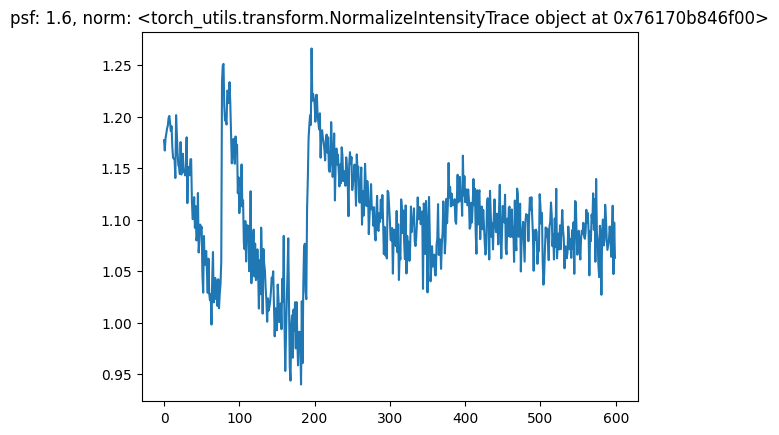

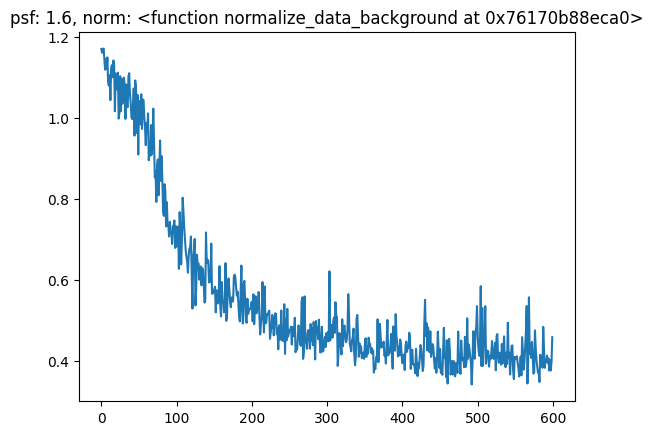

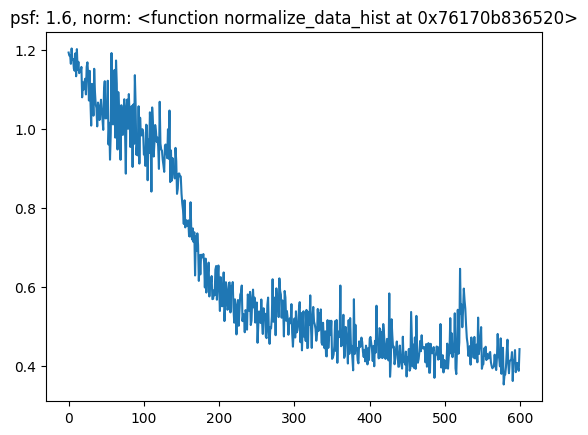

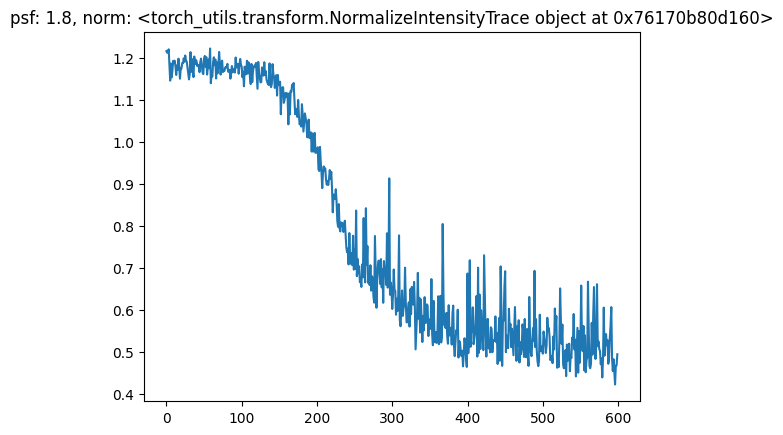

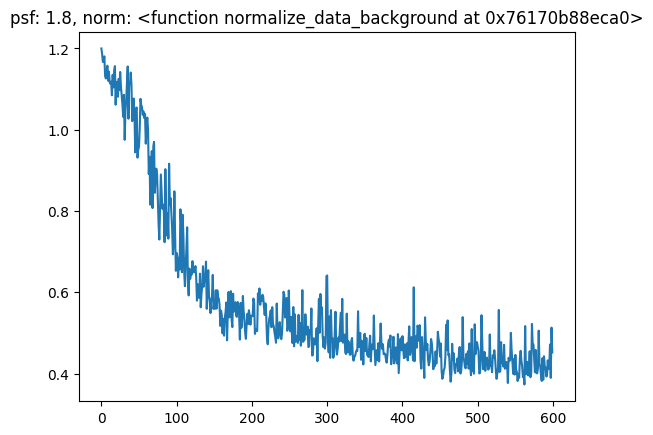

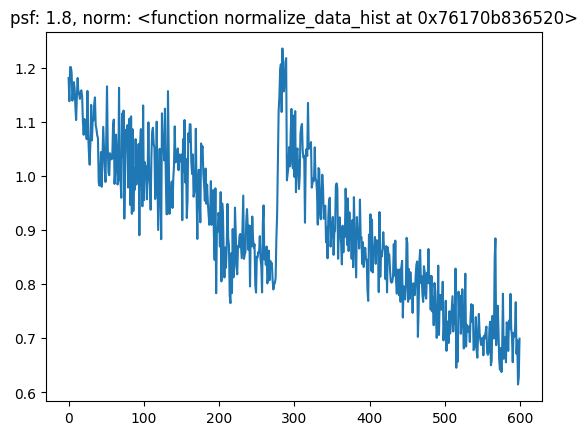

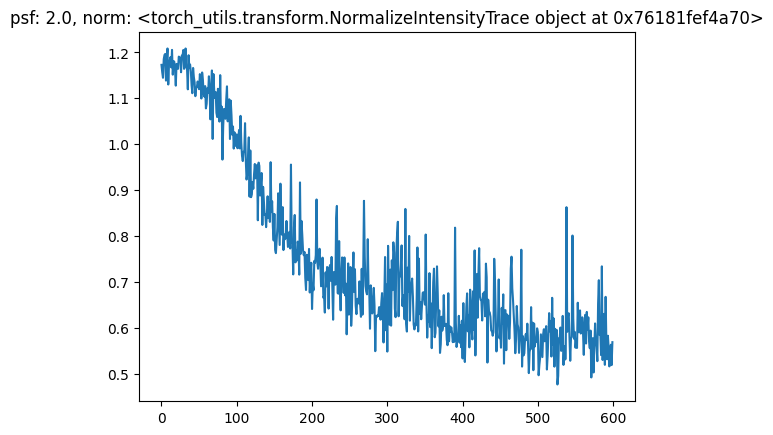

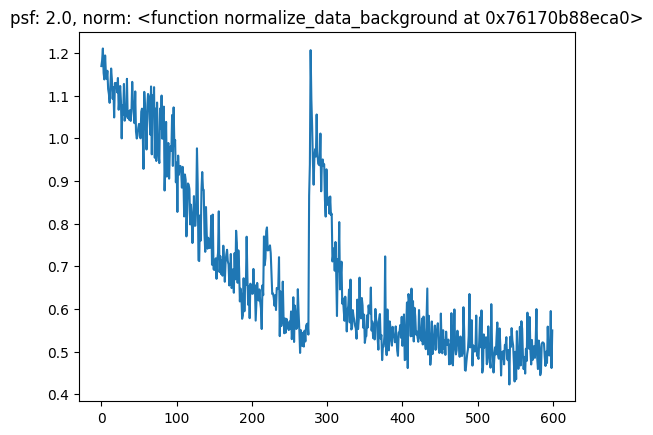

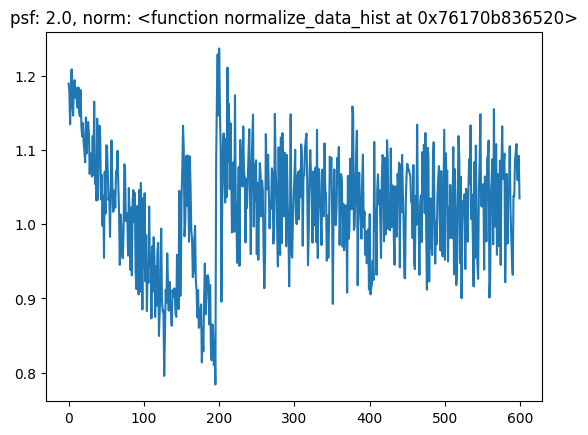

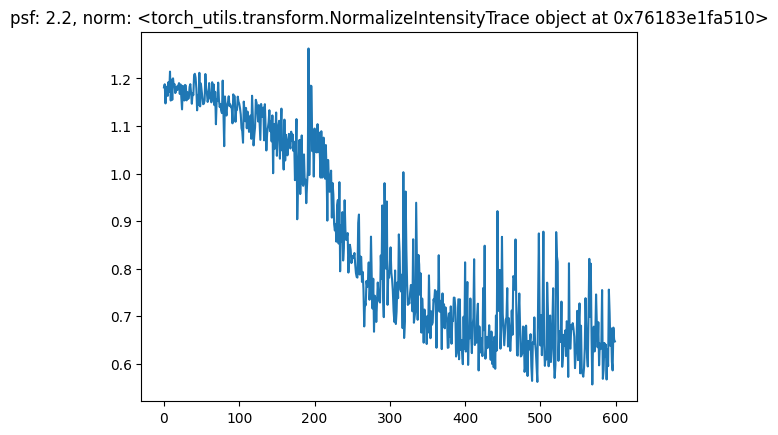

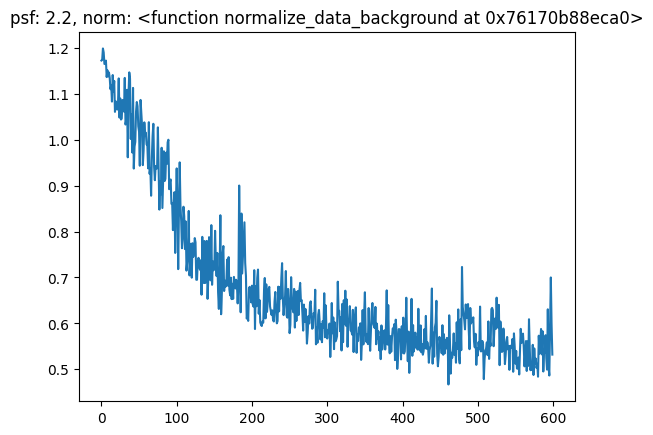

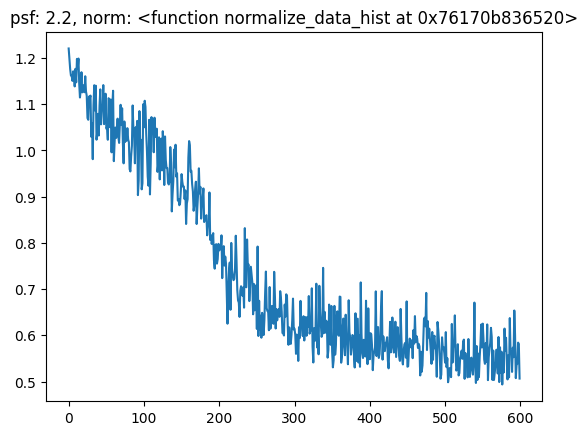

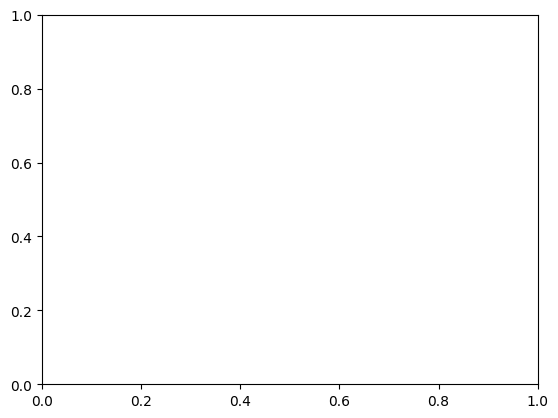

In [10]:
import matplotlib.pyplot as plt

def test_image(model, data_loader):
    with torch.no_grad():
        video, label = next(iter(data_loader))

        video = video.unsqueeze(2)
        label = label[0]

        print(video.shape)
        print(label.shape)

        segment_prediction = model(video)

        plt.imshow(segment_prediction)

        plt.subplots()

        plt.imshow(label)

for name, model_result in results.items():
    print(f'{name}, test loss result: {model_result['test_loss']}')
    plt.plot(model_result['losses'])
    plt.title(name)
    plt.subplots()
    # test_image(model_result['model'], model['data'])

In [1]:

for name, model_result in results.items():
    model = model_result['model']
    data_loader = model_result['data']

    test_image(model, data_loader)

NameError: name 'results' is not defined